In [1]:
import pandas as pd
import numpy as np


# Panda example

In [2]:
df = pd.read_csv("data/RLDataForCL60.csv",sep=';', parse_dates=[0])

In [3]:
df.head()

,UTC0,Input0,134_0,76_0,125_0 (Info_to_ignore: TickSize: 0.01 PointValue: 1000)
0,2019-01-04 11:00:00,48.69,0.478261,71.577411,2.311410
1,2019-01-04 12:00:00,48.88,0.434783,73.889657,2.710653
2,2019-01-04 13:00:00,48.63,0.391304,66.252309,2.185333
3,2019-01-04 13:47:00,48.79,0.357246,68.496609,2.521538
4,2019-01-04 14:29:00,48.83,0.326812,69.050739,2.605589


In [4]:
df.dtypes

UTC0                                                       datetime64[ns]
Input0                                                            float64
134_0                                                             float64
76_0                                                              float64
125_0 (Info_to_ignore: TickSize: 0.01 PointValue: 1000)           float64
dtype: object

# Directly to Numpy

Or use directly numpy as dates are not needed

In [5]:
data = np.genfromtxt("data/RLDataForCL60.csv",delimiter=';',skip_header=1,  dtype="float_")[:,1:]  # or  use usecols=(1,2,3,..) and no [:,1:]

In [10]:
data[0:5]

array([[48.69      ,  0.47826087, 71.57741085,  2.31140996],
       [48.88      ,  0.43478261, 73.88965726,  2.7106535 ],
       [48.63      ,  0.39130435, 66.25230913,  2.18533305],
       [48.79      ,  0.35724638, 68.49660906,  2.52153814],
       [48.83      ,  0.32681159, 69.05073924,  2.60558941]])

# Scaling

Scaling next, price not! which is used to calculate reward not a feature, if feature add separately MLIndicatorI 13 = Close
Sacling can be other too like [-1 - 1] 

In [11]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0.1, 1))


In [12]:
features = data[:,1:] # price removed, column 1

In [13]:
scaler.fit(features)   # this need to be put to Dim 2 not to dim 3 values next
scaledFeatures = scaler.transform(features)

In [14]:
scaledFeatures[0:5]  # just head

array([[0.54864048, 0.87527158, 0.71767151],
       [0.50785498, 0.90803152, 0.75684043],
       [0.46706949, 0.79982548, 0.70530238],
       [0.43512085, 0.83162275, 0.73828673],
       [0.406571  , 0.83947367, 0.74653282]])

## * Just some visualization *

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline

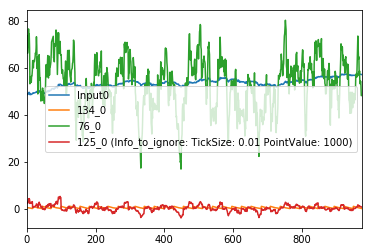

In [16]:
 df.plot();

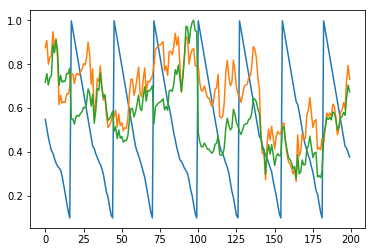

In [17]:
plt.plot(scaledFeatures[:200]) # part
plt.show()

## Feature chunks or lookbacks

You might want to use additional history values for a single bar prediction, not only the current values

In [18]:
featureMultifier = 8  # or at least 1 -> at same time modify the features to 3-dim array suitable for conv/lstm training

In [20]:
# first to a 3-d array minimum
# current format,,, n lines, feature count
scaledFeatures.shape

(976, 3)

In [21]:
# min data format (samples, timesteps, features)  # timesteps is 1 
scaledFeatures3D = np.reshape(scaledFeatures, (scaledFeatures.shape[0], 1, scaledFeatures.shape[1]))

In [24]:
scaledFeatures3D[0:5]

array([[[0.54864048, 0.87527158, 0.71767151]],

       [[0.50785498, 0.90803152, 0.75684043]],

       [[0.46706949, 0.79982548, 0.70530238]],

       [[0.43512085, 0.83162275, 0.73828673]],

       [[0.406571  , 0.83947367, 0.74653282]]])

In [38]:
def make_timesteps(a, timesteps):  ## lets do some additional timesteps backwards
        array = []
        for j in np.arange(len(a)):
            unit = []
            for i in range(timesteps):
                unit.append(np.roll(a, i, axis=0)[j])
            array.append(unit)
        return np.array(array[timesteps-1:])      ## see, the new array is no more full length if timesteps over 1, price vector need to be shortened as well

In [39]:
scaledFeatures3D1 = make_timesteps(scaledFeatures, 1)  # should be same as after reshape 1
scaledFeatures3D1[0:5]

array([[[0.54864048, 0.87527158, 0.71767151]],

       [[0.50785498, 0.90803152, 0.75684043]],

       [[0.46706949, 0.79982548, 0.70530238]],

       [[0.43512085, 0.83162275, 0.73828673]],

       [[0.406571  , 0.83947367, 0.74653282]]])

In [40]:
make_timesteps(scaledFeatures, 3)[:6]  # just an example, seems okay, starting with full boundary! 2 item removed as 3 used


array([[[0.46706949, 0.79982548, 0.70530238],
        [0.50785498, 0.90803152, 0.75684043],
        [0.54864048, 0.87527158, 0.71767151]],

       [[0.43512085, 0.83162275, 0.73828673],
        [0.46706949, 0.79982548, 0.70530238],
        [0.50785498, 0.90803152, 0.75684043]],

       [[0.406571  , 0.83947367, 0.74653282],
        [0.43512085, 0.83162275, 0.73828673],
        [0.46706949, 0.79982548, 0.70530238]],

       [[0.39501511, 0.94746658, 0.88877784],
        [0.406571  , 0.83947367, 0.74653282],
        [0.43512085, 0.83162275, 0.73828673]],

       [[0.37054381, 0.87716893, 0.85167045],
        [0.39501511, 0.94746658, 0.88877784],
        [0.406571  , 0.83947367, 0.74653282]],

       [[0.35015106, 0.91636851, 0.90939306],
        [0.37054381, 0.87716893, 0.85167045],
        [0.39501511, 0.94746658, 0.88877784]]])